In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

In [77]:
# pip install imblearn

In [117]:
loan_df = pd.read_csv('/home/student/application_train.csv')

# Column Description with their relevance to loan application
## Personal and Demographic Information
CODE_GENDER: Gender of the applicant. This feature can help capture behavioral differences that may indirectly influence credit risk (but be mindful of fairness in using this variable).<br>
FLAG_OWN_CAR and FLAG_OWN_REALTY: Indicates whether the applicant owns a car or real estate. Ownership of assets typically correlates with lower credit risk because these can serve as collateral or demonstrate financial stability.<br>
CNT_CHILDREN: Number of children in the household. More dependents can lead to higher financial obligations, potentially increasing default risk.<br>
DAYS_BIRTH: The age of the applicant (in days). Age can impact credit risk, with younger individuals often seen as higher risk, but it could also correlate with different financial behaviors.<br>
OCCUPATION_TYPE: This reflects the applicant's profession. Certain professions are more stable (e.g., government jobs) and could indicate lower risk compared to more unstable occupations.<br>
NAME_EDUCATION_TYPE: Education level can affect loan decisions since higher education is often associated with better job stability and income.<br>
NAME_FAMILY_STATUS: Marital status might influence financial stability, with married individuals often seen as more stable.<br>
CNT_FAM_MEMBERS: Number of family members, similar to children count, indicates financial dependency, which might increase credit risk.<br>

## Income and Loan Details
AMT_INCOME_TOTAL: Total annual income of the applicant. Higher income typically implies greater ability to repay the loan.<br>
AMT_CREDIT: Total amount of credit requested. A larger requested loan amount relative to income might increase risk.<br>
AMT_ANNUITY: The annual loan repayment amount. The proportion of annuity to income<br>(AMT_ANNUITY/AMT_INCOME_TOTAL) can indicate loan affordability.<br>
AMT_GOODS_PRICE: The price of the goods for which the loan is taken (e.g., equipment or seeds for farmers). This may help assess whether the loan is reasonable compared to income and other factors.<br>

## Employment Information
DAYS_EMPLOYED: How long the applicant has been employed. Longer employment periods are usually associated with greater stability and a lower likelihood of default.<br>
FLAG_EMP_PHONE: Indicates whether the applicant provided a work phone. Providing more contact details can be an indicator of transparency and stability.<br>
FLAG_WORK_PHONE, FLAG_MOBIL, FLAG_PHONE, FLAG_EMAIL: These flags indicate whether the applicant provided various forms of contact. Availability of contact information might help reduce risk, as the bank can reach the applicant more easily.<br>


## External Scores
EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3: External credit scores or sources. These scores are likely provided by credit bureaus or other third-party sources and are highly relevant for predicting creditworthiness.

## Housing and Property Features
NAME_HOUSING_TYPE: Type of housing (e.g., apartment, house). Certain housing types could be associated with more financial stability.<br>
APARTMENTS_AVG, FLOORSMAX_AVG, YEARS_BUILD_AVG: These features describe the condition or characteristics of the applicant’s property. Newer or more valuable property can indicate better financial security.<br>
OWN_CAR_AGE: Age of the applicant's car. A newer car might be a proxy for financial status.<br>
LANDAREA_AVG, LIVINGAREA_AVG, COMMONAREA_AVG: Average sizes of various areas of the property. Larger or better-maintained properties can imply higher wealth and lower credit risk.<br>


## Regional and Population Features
REGION_POPULATION_RELATIVE: This reflects the relative population of the region where the applicant lives. Living in a densely populated region might impact the economic opportunities available and influence loan decisions.<br>
REG_REGION_NOT_LIVE_REGION, REG_CITY_NOT_LIVE_CITY: Flags indicating whether the applicant's work region is different from their living region. This might affect commuting costs or job stability.<br>


## Loan Application Information
NAME_CONTRACT_TYPE: The type of loan contract (cash loans, revolving loans). Different loan types might have different risk profiles (e.g., revolving credit is generally riskier than installment loans).<br>
WEEKDAY_APPR_PROCESS_START and HOUR_APPR_PROCESS_START: The day and hour the application was started. These features could capture certain behavioral patterns, such as applying for loans at certain times of the week when individuals might be more or less rational.<br>

## Document Flags and Credit Bureau Requests
FLAG_DOCUMENT_*: Flags indicating which documents the applicant provided. Missing important documents might indicate higher risk.<br>
AMT_REQ_CREDIT_BUREAU_*: The number of credit bureau inquiries over different time periods (hour, day, week, month, quarter, year). Frequent credit bureau checks might suggest financial distress or higher risk.<br>

## Behavioral and Social Features
OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE: These features count the number of observations of the applicant’s social circle, which might be proxies for peer influence and social stability. Defaults within their social circle may signal increased risk.<br>
DAYS_LAST_PHONE_CHANGE: The number of days since the applicant last changed their phone. Frequent phone changes could indicate instability or potential fraud.<br>

### Define a dictionary with the current column names and their new names

In [118]:
new_column_names = {
    'SK_ID_CURR': 'client_id',
    'TARGET': 'loan_status',
    'NAME_CONTRACT_TYPE': 'loan_type',
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'owns_car',
    'FLAG_OWN_REALTY': 'owns_property',
    'CNT_CHILDREN': 'num_children',
    'AMT_INCOME_TOTAL': 'total_income',
    'AMT_CREDIT': 'credit_amount',
    'AMT_ANNUITY': 'annuity_amount',
    'AMT_GOODS_PRICE': 'goods_price',
    'NAME_TYPE_SUITE': 'accompaniment_type',
    'NAME_INCOME_TYPE': 'income_type',
    'NAME_EDUCATION_TYPE': 'education_level',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'REGION_POPULATION_RELATIVE': 'region_population_relative',
    'DAYS_BIRTH': 'age_in_days',
    'DAYS_EMPLOYED': 'days_employed',
    'DAYS_REGISTRATION': 'days_registered',
    'DAYS_ID_PUBLISH': 'days_ID_published',
    'OWN_CAR_AGE': 'car_age',
    'FLAG_MOBIL': 'has_mobile',
    'FLAG_EMP_PHONE': 'has_work_phone',
    'FLAG_WORK_PHONE': 'has_work_phone_alt',
    'FLAG_CONT_MOBILE': 'has_contactable_mobile',
    'FLAG_PHONE': 'has_phone',
    'FLAG_EMAIL': 'has_email',
    'OCCUPATION_TYPE': 'occupation',
    'CNT_FAM_MEMBERS': 'family_size',
    'REGION_RATING_CLIENT': 'region_rating',
    'REGION_RATING_CLIENT_W_CITY': 'region_rating_with_city',
    'WEEKDAY_APPR_PROCESS_START': 'application_weekday',
    'HOUR_APPR_PROCESS_START': 'application_hour',
    'REG_REGION_NOT_LIVE_REGION': 'region_not_living',
    'REG_REGION_NOT_WORK_REGION': 'region_not_working',
    'LIVE_REGION_NOT_WORK_REGION': 'living_region_not_work_region',
    'REG_CITY_NOT_LIVE_CITY': 'city_not_living',
    'REG_CITY_NOT_WORK_CITY': 'city_not_working',
    'LIVE_CITY_NOT_WORK_CITY': 'living_city_not_work_city',
    'ORGANIZATION_TYPE': 'employer_type',
    'EXT_SOURCE_1': 'external_score_1',
    'EXT_SOURCE_2': 'external_score_2',
    'EXT_SOURCE_3': 'external_score_3',
    'APARTMENTS_AVG': 'apartment_average_size',
    'BASEMENTAREA_AVG': 'basement_average_area',
    'YEARS_BEGINEXPLUATATION_AVG': 'years_since_building_use',
    'YEARS_BUILD_AVG': 'building_age',
    'COMMONAREA_AVG': 'common_area_avg',
    'ELEVATORS_AVG': 'elevators_avg',
    'ENTRANCES_AVG': 'entrances_avg',
    'FLOORSMAX_AVG': 'max_floors_avg',
    'FLOORSMIN_AVG': 'min_floors_avg',
    'LANDAREA_AVG': 'land_area_avg',
    'LIVINGAPARTMENTS_AVG': 'living_apartments_avg',
    'LIVINGAREA_AVG': 'living_area_avg',
    'NONLIVINGAPARTMENTS_AVG': 'non_living_apartments_avg',
    'NONLIVINGAREA_AVG': 'non_living_area_avg',
    'APARTMENTS_MODE': 'apartment_mode',
    'BASEMENTAREA_MODE': 'basement_mode',
    'YEARS_BEGINEXPLUATATION_MODE': 'years_building_use_mode',
    'YEARS_BUILD_MODE': 'building_age_mode',
    'COMMONAREA_MODE': 'common_area_mode',
    'ELEVATORS_MODE': 'elevators_mode',
    'ENTRANCES_MODE': 'entrances_mode',
    'FLOORSMAX_MODE': 'max_floors_mode',
    'FLOORSMIN_MODE': 'min_floors_mode',
    'LANDAREA_MODE': 'land_area_mode',
    'LIVINGAPARTMENTS_MODE': 'living_apartments_mode',
    'LIVINGAREA_MODE': 'living_area_mode',
    'NONLIVINGAPARTMENTS_MODE': 'non_living_apartments_mode',
    'NONLIVINGAREA_MODE': 'non_living_area_mode',
    'APARTMENTS_MEDI': 'apartment_median_size',
    'BASEMENTAREA_MEDI': 'basement_median_area',
    'YEARS_BEGINEXPLUATATION_MEDI': 'years_building_use_median',
    'YEARS_BUILD_MEDI': 'building_age_median',
    'COMMONAREA_MEDI': 'common_area_median',
    'ELEVATORS_MEDI': 'elevators_median',
    'ENTRANCES_MEDI': 'entrances_median',
    'FLOORSMAX_MEDI': 'max_floors_median',
    'FLOORSMIN_MEDI': 'min_floors_median',
    'LANDAREA_MEDI': 'land_area_median',
    'LIVINGAPARTMENTS_MEDI': 'living_apartments_median',
    'LIVINGAREA_MEDI': 'living_area_median',
    'NONLIVINGAPARTMENTS_MEDI': 'non_living_apartments_median',
    'NONLIVINGAREA_MEDI': 'non_living_area_median',
    'FONDKAPREMONT_MODE': 'house_fund_mode',
    'HOUSETYPE_MODE': 'house_type_mode',
    'TOTALAREA_MODE': 'total_area_mode',
    'WALLSMATERIAL_MODE': 'walls_material_mode',
    'EMERGENCYSTATE_MODE': 'emergency_state_mode',
    'OBS_30_CNT_SOCIAL_CIRCLE': 'social_circle_obs_30',
    'DEF_30_CNT_SOCIAL_CIRCLE': 'social_circle_def_30',
    'OBS_60_CNT_SOCIAL_CIRCLE': 'social_circle_obs_60',
    'DEF_60_CNT_SOCIAL_CIRCLE': 'social_circle_def_60',
    'DAYS_LAST_PHONE_CHANGE': 'days_since_last_phone_change',
    'FLAG_DOCUMENT_2': 'flag_document_2',
    'FLAG_DOCUMENT_3': 'flag_document_3',
    'FLAG_DOCUMENT_4': 'flag_document_4',
    'FLAG_DOCUMENT_5': 'flag_document_5',
    'FLAG_DOCUMENT_6': 'flag_document_6',
    'FLAG_DOCUMENT_7': 'flag_document_7',
    'FLAG_DOCUMENT_8': 'flag_document_8',
    'FLAG_DOCUMENT_9': 'flag_document_9',
    'FLAG_DOCUMENT_10': 'flag_document_10',
    'FLAG_DOCUMENT_11': 'flag_document_11',
    'FLAG_DOCUMENT_12': 'flag_document_12',
    'FLAG_DOCUMENT_13': 'flag_document_13',
    'FLAG_DOCUMENT_14': 'flag_document_14',
    'FLAG_DOCUMENT_15': 'flag_document_15',
    'FLAG_DOCUMENT_16': 'flag_document_16',
    'FLAG_DOCUMENT_17': 'flag_document_17',
    'FLAG_DOCUMENT_18': 'flag_document_18',
    'FLAG_DOCUMENT_19': 'flag_document_19',
    'FLAG_DOCUMENT_20': 'flag_document_20',
    'FLAG_DOCUMENT_21': 'flag_document_21',
    'AMT_REQ_CREDIT_BUREAU_HOUR': 'credit_requests_hour',
    'AMT_REQ_CREDIT_BUREAU_DAY': 'credit_requests_day',
    'AMT_REQ_CREDIT_BUREAU_WEEK': 'credit_requests_week',
    'AMT_REQ_CREDIT_BUREAU_MON': 'credit_requests_month',
    'AMT_REQ_CREDIT_BUREAU_QRT': 'credit_requests_quarter',
    'AMT_REQ_CREDIT_BUREAU_YEAR': 'credit_requests_year'
}

### Apply renaming to the dataframe
loan_df.rename(columns=new_column_names, inplace=True)

In [21]:
# loan_df.isnull().sum()

# Data Cleaning

# Imputation Techniques
Mean/Mode Imputation: For numerical columns, I have filled in the missing values with the mean. This approach is simple but can reduce variance in the data.

In [5]:
# loan_df['AMT_INCOME_TOTAL'].fillna(loan_df['AMT_INCOME_TOTAL'].mean(), inplace=True)

In [126]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

missing_values = loan_df.isnull().sum()
print(missing_values)

missing_columns = missing_values[missing_values > 0]
print(missing_columns)

client_id                        0
loan_status                      0
loan_type                        0
gender                           0
owns_car                         0
owns_property                    0
num_children                     0
total_income                     0
credit_amount                    0
annuity_amount                   0
goods_price                      0
accompaniment_type               0
income_type                      0
education_level                  0
family_status                    0
housing_type                     0
region_population_relative       0
age_in_days                      0
days_employed                    0
days_registered                  0
days_ID_published                0
car_age                          0
has_mobile                       0
has_work_phone                   0
has_work_phone_alt               0
has_contactable_mobile           0
has_phone                        0
has_email                        0
occupation          

In [120]:
loan_df['annuity_amount'] = loan_df.groupby(['total_income', 'income_type'])['annuity_amount'].transform(lambda x: x.ffill().bfill())

## Filling in the numerical columns using the 25th Percentile
This method helps maintain the original distribution of your data. It ensures that the filled values are still within the range of the existing data. Also, In contexts like risk assessment, using lower percentiles can be particularly appropriate, as it might better represent a cautious estimate of the missing values.


Also, the 25th percentile is less affected by outliers(extremely high or low values) compared to the average(mean)

In [121]:
loan_df['goods_price'] = loan_df['goods_price'].fillna(loan_df['goods_price'].quantile(0.25))
loan_df['car_age'] = loan_df['car_age'].fillna(loan_df['car_age'].quantile(0.25))
loan_df['credit_requests_hour'] = loan_df['credit_requests_hour'].fillna(loan_df['credit_requests_hour'].quantile(0.25))
loan_df['credit_requests_day'] = loan_df['credit_requests_day'].fillna(loan_df['credit_requests_day'].quantile(0.25))
loan_df['credit_requests_week'] = loan_df['credit_requests_week'].fillna(loan_df['credit_requests_week'].quantile(0.25))
loan_df['credit_requests_month'] = loan_df['credit_requests_month'].fillna(loan_df['credit_requests_month'].quantile(0.25))
loan_df['credit_requests_quarter'] = loan_df['credit_requests_quarter'].fillna(loan_df['credit_requests_quarter'].quantile(0.25))
loan_df['accompaniment_type'] = loan_df['accompaniment_type'].fillna(loan_df['accompaniment_type'].mode()[0])  # Using mode for categorical data
loan_df['entrances_median'] = loan_df['entrances_median'].fillna(loan_df['credit_requests_year'].quantile(0.25))
loan_df['living_area_median'] = loan_df['living_area_median'].fillna(loan_df['credit_requests_year'].quantile(0.25))
loan_df['days_since_last_phone_change'] = loan_df['days_since_last_phone_change'].fillna(loan_df['credit_requests_year'].quantile(0.25))
loan_df['external_score_1'] = loan_df['external_score_1'].fillna(loan_df['external_score_1'].quantile(0.25))
loan_df['external_score_2'] = loan_df['external_score_2'].fillna(loan_df['external_score_2'].quantile(0.25))
loan_df['external_score_3'] = loan_df['external_score_3'].fillna(loan_df['external_score_3'].quantile(0.25))
loan_df['social_circle_obs_30'] = loan_df['social_circle_obs_30'].fillna(loan_df['credit_requests_year'].quantile(0.25))
loan_df['social_circle_def_30'] = loan_df['social_circle_def_30'].fillna(loan_df['credit_requests_year'].quantile(0.25))
loan_df['social_circle_obs_60'] = loan_df['social_circle_obs_60'].fillna(loan_df['credit_requests_year'].quantile(0.25))
loan_df['social_circle_def_60'] = loan_df['social_circle_def_60'].fillna(loan_df['credit_requests_year'].quantile(0.25))
loan_df['non_living_apartments_median'] = loan_df['non_living_apartments_median'].fillna(loan_df['non_living_apartments_median'].quantile(0.25))
loan_df['land_area_mode'] = loan_df['land_area_mode'].fillna(loan_df['land_area_mode'].quantile(0.25))
loan_df['living_apartments_mode'] = loan_df['living_apartments_mode'].fillna(loan_df['living_apartments_mode'].quantile(0.25))
loan_df['living_area_mode'] = loan_df['living_area_mode'].fillna(loan_df['living_area_mode'].quantile(0.25))
loan_df['non_living_apartments_mode'] = loan_df['non_living_apartments_mode'].fillna(loan_df['non_living_apartments_mode'].quantile(0.25))
loan_df['non_living_area_mode'] = loan_df['non_living_area_mode'].fillna(loan_df['non_living_area_mode'].quantile(0.25))
loan_df['apartment_median_size'] = loan_df['apartment_median_size'].fillna(loan_df['apartment_median_size'].quantile(0.25))
loan_df['entrances_avg'] = loan_df['entrances_avg'].fillna(loan_df['entrances_avg'].quantile(0.25))
loan_df['basement_median_area'] = loan_df['basement_median_area'].fillna(loan_df['basement_median_area'].quantile(0.25))
loan_df['years_building_use_median'] = loan_df['years_building_use_median'].fillna(loan_df['years_building_use_median'].quantile(0.25))
loan_df['building_age_median'] = loan_df['building_age_median'].fillna(loan_df['building_age_median'].quantile(0.25))
loan_df['living_apartments_avg'] = loan_df['living_apartments_avg'].fillna(loan_df['living_apartments_avg'].quantile(0.25))
loan_df['non_living_apartments_avg'] = loan_df['non_living_apartments_avg'].fillna(loan_df['non_living_apartments_avg'].quantile(0.25))
loan_df['common_area_median'] = loan_df['common_area_median'].fillna(loan_df['common_area_median'].quantile(0.25))
loan_df['elevators_median'] = loan_df['elevators_median'].fillna(loan_df['elevators_median'].quantile(0.25))
loan_df['max_floors_median'] = loan_df['max_floors_median'].fillna(loan_df['max_floors_median'].quantile(0.25))
loan_df['min_floors_median'] = loan_df['min_floors_median'].fillna(loan_df['min_floors_median'].quantile(0.25))
loan_df['land_area_median'] = loan_df['land_area_median'].fillna(loan_df['land_area_median'].quantile(0.25))
loan_df['living_apartments_median'] = loan_df['living_apartments_median'].fillna(loan_df['living_apartments_median'].quantile(0.25))
loan_df['non_living_apartments_median'] = loan_df['non_living_apartments_median'].fillna(loan_df['non_living_apartments_median'].quantile(0.25))
loan_df['non_living_area_median'] = loan_df['non_living_area_median'].fillna(loan_df['non_living_area_median'].quantile(0.25))
loan_df['living_area_avg'] = loan_df['living_area_avg'].fillna(loan_df['living_area_avg'].quantile(0.25))
loan_df['family_size'] = loan_df['family_size'].fillna(loan_df['family_size'].quantile(0.25))
loan_df['non_living_area_avg'] = loan_df['non_living_area_avg'].fillna(loan_df['non_living_area_avg'].quantile(0.25))
loan_df['total_area_mode'] = loan_df['total_area_mode'].fillna(loan_df['total_area_mode'].quantile(0.25))
loan_df['annuity_amount'] = loan_df['annuity_amount'].fillna(loan_df['annuity_amount'].quantile(0.25))

In [122]:
# Fill missing values with the 25th percentile
loan_df['goods_price'] = loan_df['goods_price'].fillna(loan_df['goods_price'].quantile(0.25))

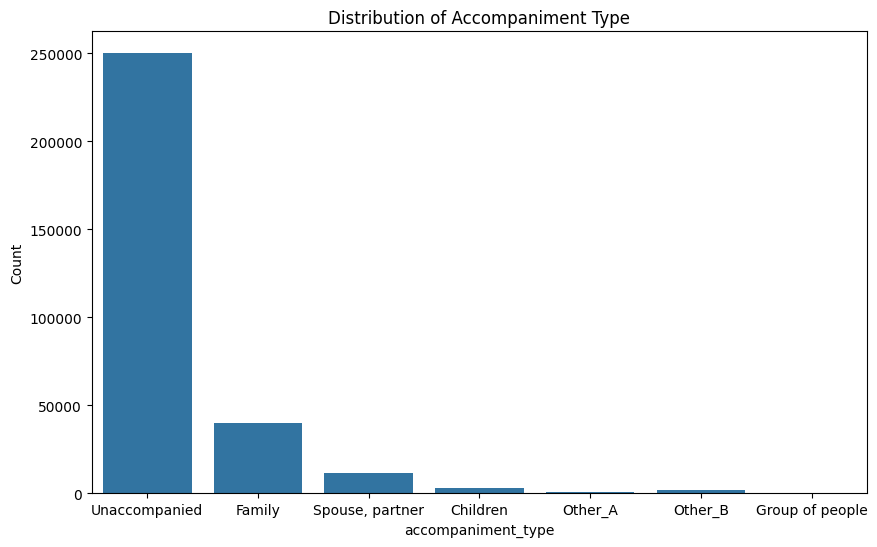

In [124]:
# Count plot for categorical variable
plt.figure(figsize=(10, 6))
sns.countplot(data=loan_df, x='accompaniment_type')
plt.title('Distribution of Accompaniment Type')
plt.ylabel('Count')
plt.show()

In [44]:
# loan_df['occupation'].fillna(loan_df['occupation'].mode()[0], inplace=True)

# Filling in the missing values in the categorical columns using the mode
Mode-based imputation is less likely to overfit the model compared to group-based imputation, as it doesn’t rely on specific group characteristics.<br>

It also ensures that the filled values are meaningful and relevant, while preserving the integrity of the dataset.

In [125]:
# Fill missing values with mode for categorical columns
loan_df['max_floors_mode'] = loan_df['max_floors_mode'].fillna(loan_df['max_floors_mode'].mode()[0])
loan_df['occupation'] = loan_df['occupation'].fillna(loan_df['occupation'].mode()[0])
loan_df['min_floors_mode'] = loan_df['min_floors_mode'].fillna(loan_df['min_floors_mode'].mode()[0])
loan_df['elevators_mode'] = loan_df['elevators_mode'].fillna(loan_df['elevators_mode'].mode()[0])
loan_df['apartment_average_size'] = loan_df['apartment_average_size'].fillna(loan_df['apartment_average_size'].mode()[0])
loan_df['basement_average_area'] = loan_df['basement_average_area'].fillna(loan_df['basement_average_area'].mode()[0])
loan_df['years_since_building_use'] = loan_df['years_since_building_use'].fillna(loan_df['years_since_building_use'].mode()[0])
loan_df['building_age'] = loan_df['building_age'].fillna(loan_df['building_age'].mode()[0])
loan_df['common_area_avg'] = loan_df['common_area_avg'].fillna(loan_df['common_area_avg'].mode()[0])
loan_df['elevators_avg'] = loan_df['elevators_avg'].fillna(loan_df['elevators_avg'].mode()[0])
loan_df['entrances_avg'] = loan_df['entrances_avg'].fillna(loan_df['entrances_avg'].mode()[0])
loan_df['max_floors_avg'] = loan_df['max_floors_avg'].fillna(loan_df['max_floors_avg'].mode()[0])
loan_df['min_floors_avg'] = loan_df['min_floors_avg'].fillna(loan_df['min_floors_avg'].mode()[0])
loan_df['land_area_avg'] = loan_df['land_area_avg'].fillna(loan_df['land_area_avg'].mode()[0])
loan_df['living_apartments_avg'] = loan_df['living_apartments_avg'].fillna(loan_df['living_apartments_avg'].mode()[0])
loan_df['non_living_apartments_avg'] = loan_df['non_living_apartments_avg'].fillna(loan_df['non_living_apartments_avg'].mode()[0])
loan_df['apartment_mode'] = loan_df['apartment_mode'].fillna(loan_df['apartment_mode'].mode()[0])
loan_df['basement_mode'] = loan_df['basement_mode'].fillna(loan_df['basement_mode'].mode()[0])
loan_df['years_building_use_mode'] = loan_df['years_building_use_mode'].fillna(loan_df['years_building_use_mode'].mode()[0])
loan_df['building_age_mode'] = loan_df['building_age_mode'].fillna(loan_df['building_age_mode'].mode()[0])
loan_df['house_fund_mode'] = loan_df['house_fund_mode'].fillna(loan_df['common_area_mode'].mode()[0])
loan_df['walls_material_mode'] = loan_df['walls_material_mode'].fillna(loan_df['house_type_mode'].mode()[0])
loan_df['emergency_state_mode'] = loan_df['emergency_state_mode'].fillna(loan_df['emergency_state_mode'].mode()[0])
loan_df['entrances_mode'] = loan_df['entrances_mode'].fillna(loan_df['entrances_mode'].mode()[0])
loan_df['house_type_mode'] = loan_df['house_type_mode'].fillna(loan_df['house_type_mode'].mode()[0])
loan_df['occupation'] = loan_df['occupation'].fillna(loan_df['occupation'].mode()[0])
loan_df['common_area_mode'] = loan_df['common_area_mode'].fillna(loan_df['common_area_mode'].mode()[0])
loan_df['credit_requests_year'] = loan_df['credit_requests_year'].fillna(loan_df['credit_requests_year'].mode()[0])

In [127]:
# Fill missing values with mode for categorical columns
loan_df['max_floors_mode'] = loan_df['max_floors_mode'].fillna(loan_df['max_floors_mode'].mode()[0])
loan_df['occupation'] = loan_df['occupation'].fillna(loan_df['occupation'].mode()[0])
loan_df['min_floors_mode'] = loan_df['min_floors_mode'].fillna(loan_df['min_floors_mode'].mode()[0])
loan_df['elevators_mode'] = loan_df['elevators_mode'].fillna(loan_df['elevators_mode'].mode()[0])
loan_df['apartment_average_size'] = loan_df['apartment_average_size'].fillna(loan_df['apartment_average_size'].mode()[0])
loan_df['basement_average_area'] = loan_df['basement_average_area'].fillna(loan_df['basement_average_area'].mode()[0])
loan_df['years_since_building_use'] = loan_df['years_since_building_use'].fillna(loan_df['years_since_building_use'].mode()[0])
loan_df['building_age'] = loan_df['building_age'].fillna(loan_df['building_age'].mode()[0])
loan_df['common_area_avg'] = loan_df['common_area_avg'].fillna(loan_df['common_area_avg'].mode()[0])
loan_df['elevators_avg'] = loan_df['elevators_avg'].fillna(loan_df['elevators_avg'].mode()[0])
loan_df['entrances_avg'] = loan_df['entrances_avg'].fillna(loan_df['entrances_avg'].mode()[0])
loan_df['max_floors_avg'] = loan_df['max_floors_avg'].fillna(loan_df['max_floors_avg'].mode()[0])
loan_df['min_floors_avg'] = loan_df['min_floors_avg'].fillna(loan_df['min_floors_avg'].mode()[0])
loan_df['land_area_avg'] = loan_df['land_area_avg'].fillna(loan_df['land_area_avg'].mode()[0])
loan_df['living_apartments_avg'] = loan_df['living_apartments_avg'].fillna(loan_df['living_apartments_avg'].mode()[0])
loan_df['non_living_apartments_avg'] = loan_df['non_living_apartments_avg'].fillna(loan_df['non_living_apartments_avg'].mode()[0])
loan_df['apartment_mode'] = loan_df['apartment_mode'].fillna(loan_df['apartment_mode'].mode()[0])
loan_df['basement_mode'] = loan_df['basement_mode'].fillna(loan_df['basement_mode'].mode()[0])
loan_df['years_building_use_mode'] = loan_df['years_building_use_mode'].fillna(loan_df['years_building_use_mode'].mode()[0])
loan_df['building_age_mode'] = loan_df['building_age_mode'].fillna(loan_df['building_age_mode'].mode()[0])
loan_df['house_fund_mode'] = loan_df['house_fund_mode'].fillna(loan_df['common_area_mode'].mode()[0])
loan_df['walls_material_mode'] = loan_df['walls_material_mode'].fillna(loan_df['house_type_mode'].mode()[0])
loan_df['emergency_state_mode'] = loan_df['emergency_state_mode'].fillna(loan_df['emergency_state_mode'].mode()[0])
loan_df['entrances_mode'] = loan_df['entrances_mode'].fillna(loan_df['entrances_mode'].mode()[0])
loan_df['house_type_mode'] = loan_df['house_type_mode'].fillna(loan_df['house_type_mode'].mode()[0])
loan_df['occupation'] = loan_df['occupation'].fillna(loan_df['occupation'].mode()[0])
loan_df['common_area_mode'] = loan_df['common_area_mode'].fillna(loan_df['common_area_mode'].mode()[0])
loan_df['credit_requests_year'] = loan_df['credit_requests_year'].fillna(loan_df['credit_requests_year'].mode()[0])

In [129]:
# Convert age from days to years (absolute values to handle negative days)
loan_df['employed_years'] = abs(loan_df['days_employed']) / 365.25

# Round age_years to the nearest whole number
loan_df['employed_years'] = loan_df['employed_years'].round(0).astype(int)

# Feature Engineering
### Frequency Encoding
It helps mitigate overfitting, since it reduces the number of new columns created compared to one-hot encoding.<br>

For categorical features with many unique values (high cardinality), frequency encoding reduces dimensionality by not creating a separate binary feature for each category (as in one-hot encoding).<br>

Frequency encoding is a technique used in feature engineering to convert categorical variables into numerical representations based on the frequency of each category

In [14]:
# print(loan_df.columns)

##### Splitting the data ensures that frequency counts are derived from the training set only. Using counts from the entire dataset can lead to overfitting.

X: This is the input data (features) where I have dropped the columns that aren't needed for predictions: client_id (since it is unique, it does not show any trends) and loan_status (the outcome I am trying to predict).<br>
y: This is the target data (what I want to predict) which is the loan_status (approved or rejected).

In [130]:
# Split the data into features and target
X = loan_df.drop(columns=['client_id', 'loan_status'])
y = loan_df['loan_status']

In [131]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [132]:
# Identify categorical columns in the training set
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Apply frequency encoding for each categorical column in the training set
for col in categorical_cols:
    freq_encoding = X_train[col].value_counts()
    X_train[col + '_freq'] = X_train[col].map(freq_encoding)

In [133]:
# Drop original categorical columns from the training set after encoding
X_train.drop(columns=categorical_cols, inplace=True)

### Standardizing the numerical columns
Makes sure all features contribute equally to the model, preventing any single feature from dominating due to its scale.

In [134]:
# List of numerical columns to standardize
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [135]:
# Impute numerical columns with the mean (or median)
imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

# Step 2: Check for missing values
# print("Missing values after imputation:\n", X.isnull().sum())

# Step 3: Standardize the Numerical Columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Verify standardization
# print("Mean of standardized columns:\n", X[numerical_cols].mean())
# print("Standard deviation of standardized columns:\n", X[numerical_cols].std())

In [136]:
# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# print(X.dtypes)

In [137]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- accompaniment_type
- application_weekday
- education_level
- emergency_state_mode
- employer_type
- ...
Feature names seen at fit time, yet now missing:
- accompaniment_type_freq
- application_weekday_freq
- education_level_freq
- emergency_state_mode_freq
- employer_type_freq
- ...


Recall for Class 0: 1.00 — The model correctly identifies all actual class 0 instances.
Recall for Class 1: 0.00 — The model fails to identify any actual class 1 instances, indicating that it’s struggling to detect this class.

### SMOTE stands for Synthetic Minority Over-sampling Technique.

How SMOTE Works<br>
Identify the Minority Class: First, SMOTE looks at the class with fewer examples (the minority class), which is class 1.

Create New Examples: Instead of just copying existing examples, SMOTE creates new ones. It does this by:

Finding examples of the minority class.<br>
Looking at the neighbors (similar examples).<br>
Creating new examples in between existing ones. It’s like filling in the gaps.<br>
Balance the Dataset: By adding these synthetic examples, SMOTE helps balance the number of examples in both classes.<br>This gives your model more information to learn from

In [32]:
# pip install imbalanced-learn

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

In [29]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

In [ ]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importance_df)

# Optionally, you can plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Important Features')
plt.show()

### Confusion Matrix:
True Negatives (TN): 84,799 times it correctly predicted 0.<br>
False Positives (FP): 7 times it incorrectly predicted 1 when it was actually 0.<br>
False Negatives (FN): 7,431 times it incorrectly predicted 0 when it was actually 1.<br>
True Positives (TP): 17 times it correctly predicted 1.<br>

## Reasons for using RandForest
RandomForest often achieves high accuracy in classification tasks due to its ability to capture complex relationships in data by averaging the predictions from multiple trees.<br>
Scalability: Random Forest can handle large datasets efficiently because it builds trees independently and in parallel. This parallel processing capability allows it to scale well as the dataset size increases.<br>
Instead of relying on one decision tree (which can get too focused on the training data), Random Forest uses many trees. This helps make better predictions on new data.<br>
Random Forest can show you which features (data columns) are most important for making predictions, helping you understand your data better

## Results Explanation

### Precision for Class 0: 0.92
What it means: When the model says it’s class 0, it’s correct 92% of the time.<br>
### Recall for Class 0: 1.00
What it means: The model correctly identifies all actual class 0 instances (100% of them).<br>
### F1-Score for Class 0: 0.96
What it means: There’s a good balance between precision and recall for class 0.<br>
### Precision for Class 1: 0.71
What it means: When the model predicts class 1, it’s correct 71% of the time.<br>
### Recall for Class 1: 0.00
What it means: The model failed to identify any actual class 1 instances (0% of them).<br>
### F1-Score for Class 1: 0.00
What it means: There’s no balance between precision and recall for class 1, as it didn't correctly predict any.<br>
### Macro Average:
What it means: Average performance across classes, treating each class equally. Here, it indicates a balance issue with a lower overall performance.<br>
### Weighted Average:
What it means: Average performance that considers the size of each class. It gives a better view of how the model performs overall, especially with the imbalance.<br>

The columns external_score_1 and external_score_2 are similar to external_score_3 in that they represent scores derived from external data sources to assess a borrower's creditworthiness or risk profile. 

In [ ]:
# 3. Train the Linear SVM model
model = LinearSVC(random_state=42)
model.fit(X_train, y_train)

In [ ]:
# 4. Make predictions on the test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', report)

# Result Explanation
## Precision: 0.92:
Out of all the loans predicted as not approved (class 0), 92% were actually not approved. This means the model is good at correctly identifying loans that should not be approved.
## Recall: 1.00:
This means the model correctly identified all actual not-approved loans (class 0). If there were 56,554 not-approved loans in the test set, the model identified all of them correctly.
## F1-Score: 0.96:
This is the harmonic mean of precision and recall. It balances the two metrics and gives a score of 0.96, indicating very strong performance for class 0.
b. Class 1 (Predicted: Approved):
## Precision: 1.00:
Out of all the loans predicted as approved (class 1), 100% were actually approved. The model didn’t make any false positives for this class.
## Recall: 0.00:
This means the model failed to identify any actual approved loans (class 1). If there were 4,949 approved loans in the test set, the model did not correctly predict any of them.
## F1-Score: 0.00:
Since recall is 0, the F1-score is also 0. This indicates a poor performance for class 1.

In [ ]:
# 3. Train the Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# 4. Make predictions on the test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', report)

## LogisticRegression

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Fit the model on the entire dataset
model.fit(X, y)

# Make predictions on the test set (or a separate validation set if you have one)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores):.2f}')
print(f'Accuracy on Test Set: {accuracy:.2f}')
print('Classification Report:\n', report)

## DecisionTree

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Initialize the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

In [166]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_


In [ ]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model.fit(X_resampled, y_resampled)

In [ ]:
# Set up Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1)

In [ ]:
# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

In [ ]:
# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)